In [163]:
import os

import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import spearmanr

from tensorflow import keras
from keras import layers

import CCLE_utils
import MMRF_utils

In [2]:
ccle_data_dir = '/Users/nalinisingh/datasets/depmap/CCLE_expression.csv'
mmrf_rna_dir = '/Users/nalinisingh/datasets/multiple_myeloma/MMRF_CoMMpass_IA15a_E74GTF_Cufflinks_Gene_FPKM.txt'
rna_map_path = 'Ensembl_HGNC_map_042421.csv'

In [363]:
def normalize_genomic_data(df, mean, std):
    std[std<1e-4]=1
    norm = ((df-mean)/(std))
    norm[norm>10]=0
    return norm

## Load CCLE Data

In [261]:
ccle_ensembl = CCLE_utils.get_ccle_rnaseq_with_ensembl(ccle_data_dir, rna_map_path)

In [426]:
np.random.seed(0)
n_points = ccle_ensembl.shape[0]

n_train = int(n_points*0.7)
n_val = int(n_points*0.1)
n_test = n_points-(n_train+n_val)

train_ccle_id = ccle_ensembl.loc[:n_train,:]
valid_ccle_id = ccle_ensembl.loc[n_train:n_train+n_val,:].reset_index()
test_ccle_id = ccle_ensembl.loc[n_train+n_val:,:].reset_index()

train_ccle = ccle_ensembl.loc[:n_train,:].drop('Unnamed: 0', axis=1)
valid_ccle = ccle_ensembl.loc[n_train:n_train+n_val,:].drop('Unnamed: 0', axis=1)
test_ccle = ccle_ensembl.loc[n_train+n_val:,:].drop('Unnamed: 0', axis=1)


In [364]:
ccle_mean = train_ccle.mean()
ccle_std = train_ccle.std()
train_ccle = normalize_genomic_data(train_ccle, ccle_mean, ccle_std)
valid_ccle = normalize_genomic_data(valid_ccle, ccle_mean, ccle_std)
test_ccle = normalize_genomic_data(test_ccle, ccle_mean, ccle_std)

In [264]:
np.savez('ccle_constants.npz',ccle_mean=ccle_mean,ccle_std=ccle_std)

# Load MMRF Data

In [265]:
train_patient_all = pd.DataFrame()
valid_patient_all = pd.DataFrame()
test_patient_all = pd.DataFrame()

for ind in [1]:
    data_filename = '/Users/nalinisingh/dev/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_pfs_ind_seed0.pkl'#%(ind)
    train, test, valid = MMRF_utils.get_train_test_valid(data_filename, ind, show_features=True)

    # include the first n clinical visit data for each patient (default 0)
    train_df = MMRF_utils.preprocess_patient_data(train, num_clin_visits=3)  

    valid_df = MMRF_utils.preprocess_patient_data(valid, num_clin_visits=3)  

    test_df = MMRF_utils.preprocess_patient_data(test, num_clin_visits=3)  

    genomic_fn = '/Users/nalinisingh/datasets/multiple_myeloma/MMRF_CoMMpass_IA15a_E74GTF_Salmon_Gene_TPM.txt'
    genomic_df = MMRF_utils.preprocess_genomic_data(genomic_fn, nPCA=0)

    train_patient_all = train_patient_all.append(train_df.merge(genomic_df, left_on='pids', right_on='pids'))

    valid_patient_all = valid_patient_all.append(valid_df.merge(genomic_df, left_on='pids', right_on='pids'))

    test_patient_all = test_patient_all.append(test_df.merge(genomic_df, left_on='pids', right_on='pids'))
    



loading from: /Users/nalinisingh/dev/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_pfs_ind_seed0.pkl
pids
(494,)
x
(494, 33, 16)
m
(494, 33, 16)
feature_names_x
(16,)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
ys_seq
(494, 1)
ce
(494, 1)
feature_names_y
(1,)
['progression free survival (all)']
b
(494, 16)
feature_names
(16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
a
(494, 33, 9)
m_a
(494, 33, 6)
feature_names_a
(9,)
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']
Keep first 3 clinical visits.
Keep first 3 clinical visits.
Keep first 3 clinical visits.
Reading /Users/nalinisingh/datasets/multiple_my

In [365]:
bor_train_patient_all = train_patient_all[train_patient_all['Bor1']==True]
bor_valid_patient_all = valid_patient_all[valid_patient_all['Bor1']==True]
bor_test_patient_all = test_patient_all[test_patient_all['Bor1']==True]

In [366]:
train_pfs = train_patient_all['pfs']
valid_pfs = valid_patient_all['pfs']
test_pfs = test_patient_all['pfs']

bor_train_pfs = bor_train_patient_all['pfs']
bor_valid_pfs = bor_valid_patient_all['pfs']
bor_test_pfs = bor_test_patient_all['pfs']

In [367]:
gene_columns = ccle_ensembl.columns[1:]

mmrf_mean = train_patient_all[gene_columns].mean()
mmrf_std = train_patient_all[gene_columns].std()

train_patient_genomic = normalize_genomic_data(train_patient_all[gene_columns], mmrf_mean, mmrf_std)
valid_patient_genomic = normalize_genomic_data(valid_patient_all[gene_columns], mmrf_mean, mmrf_std)
test_patient_genomic = normalize_genomic_data(test_patient_all[gene_columns], mmrf_mean, mmrf_std)

bor_train_patient_genomic = normalize_genomic_data(bor_train_patient_all[gene_columns], mmrf_mean, mmrf_std)
bor_valid_patient_genomic = normalize_genomic_data(bor_valid_patient_all[gene_columns], mmrf_mean, mmrf_std)
bor_test_patient_genomic = normalize_genomic_data(bor_test_patient_all[gene_columns], mmrf_mean, mmrf_std)

np.savez('mmrf_constants.npz',mmrf_mean=mmrf_mean,mmrf_std=mmrf_std)

In [368]:
assert((gene_columns==train_patient_genomic.columns).all())

## Autoencoder

In [369]:
def get_autoencoder(encoding_dim):
    out_shape = train_patient_genomic.shape[1]
    # This is our input image
    input_rna = keras.Input(shape=(out_shape,))

    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(4*encoding_dim, activation='relu')(input_rna)
    encoded = layers.Dense(2*encoding_dim, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation=None)(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(4*encoding_dim, activation='relu')(encoded)                                                          
    decoded = layers.Dense(2*encoding_dim, activation='relu')(decoded)
    decoded = layers.Dense(out_shape, activation=None)(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_rna, decoded)
    autoencoder.compile(optimizer='adam', loss='MSE')
    
    return autoencoder

In [370]:
def train_ae(ae, train_data, val_data, name):
    train_dir = os.path.join('training', name)
    if(not os.path.exists(train_dir)):
        os.mkdir(train_dir)
       
    ckpt_callback = keras.callbacks.ModelCheckpoint(
        train_dir,
        monitor="val_loss",
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        options=None,
    )
       
    return ae.fit(train_data, train_data,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(val_data, val_data),
                verbose=0,
                callbacks=[ckpt_callback])

In [371]:
mmrf_ae = get_autoencoder(128)
mmrf_str = 'Re-Normalized_MMRF_AE'
mmrf_history_callback = train_ae(mmrf_ae, train_patient_genomic, valid_patient_genomic, mmrf_str)
np.savez(os.path.join('training',mmrf_str),loss = mmrf_history_callback.history['loss'],val_loss = mmrf_history_callback.history['val_loss'])

INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_MMRF_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

In [372]:
ccle_ae = get_autoencoder(128)
ccle_str = 'Re-Normalized_CCLE_AE'
ccle_history_callback = train_ae(ccle_ae, train_ccle, valid_ccle, ccle_str)
np.savez(os.path.join('training',ccle_str),loss = ccle_history_callback.history['loss'],val_loss = ccle_history_callback.history['val_loss'])

INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_CCLE_AE/assets
INFO:tensorflow:Assets written to: training/Re-Norm

In [373]:
combined_ae = get_autoencoder(128)
combined_str = 'Re-Normalized_Combined_AE'
combined_history_callback = train_ae(combined_ae, pd.concat([train_patient_genomic,train_ccle]), pd.concat([valid_patient_genomic,valid_ccle]),combined_str)
np.savez(os.path.join('training',combined_str),loss = combined_history_callback.history['loss'],val_loss = combined_history_callback.history['val_loss'])

INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets

INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets

INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets

INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets

INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets
INFO:tensorflow:Assets written to: training/Re-Normalized_Combined_AE/assets

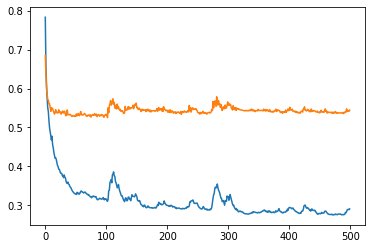

In [389]:
plt.plot(combined_history_callback.history['loss'])
plt.plot(combined_history_callback.history['val_loss'])

Text(0, 0.5, 'Predicted Component')

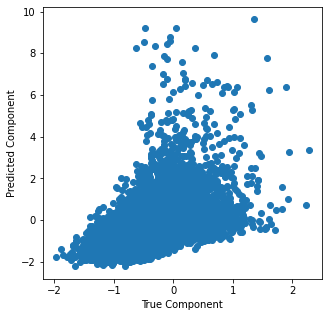

In [375]:
plt.figure(figsize=(5,5))
plt.scatter(mmrf_ae.predict(np.array(valid_patient_genomic)[1:2,:]),np.array(valid_patient_genomic)[1:2,:])
plt.xlabel('True Component')
plt.ylabel('Predicted Component')


## PFS Binary Classifications

In [376]:
def get_stats(true_pfs,pred_pfs):
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    return([np.round(metric(true_pfs, pred_pfs),2) for metric in metrics])

In [377]:
pfs_results_df = pd.DataFrame()
bin_train_pfs = train_pfs>12
bin_valid_pfs = valid_pfs>12

bor_bin_train_pfs = bor_train_pfs>12
bor_bin_valid_pfs = bor_valid_pfs>12

In [378]:
def reg_routine(train_data, train_pfs, val_data, val_pfs, label_str):
    best_val = np.inf
    best_reg = None
    best_alpha = None

    reg = RandomForestClassifier(1000,max_depth=50).fit(train_data, train_pfs)
    accuracy, precision, recall, f1 = get_stats(val_pfs, reg.predict(val_data))

    if(accuracy > best_val):
        best_val = accuracy
        best_reg = reg
        best_alpha = alpha
            
    tr_stats = get_stats(train_pfs, reg.predict(train_data))
    val_stats = get_stats(val_pfs, reg.predict(val_data))
    
    return {'Experiment': label_str,
                          'Train Accuracy': tr_stats[0],
                          'Train Precision': tr_stats[1],
                          'Train Recall': tr_stats[2],
                          'Train F1': tr_stats[3],
                          
                          'Val Accuracy': val_stats[0],
                          'Val Precision': val_stats[1],
                          'Val Recall': val_stats[2],
                          'Val F1': val_stats[3]}


In [379]:
# Raw RNA Seq
results = reg_routine(bor_train_patient_genomic, bor_bin_train_pfs, bor_valid_patient_genomic, bor_bin_valid_pfs, 'MMRF RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


In [380]:
def mmrf_ae_encode(rna_data):
    encoder = keras.Model(inputs=mmrf_ae.input, outputs=mmrf_ae.layers[3].output)
    return(encoder(rna_data))

def ccle_ae_encode(rna_data):
    encoder = keras.Model(inputs=ccle_ae.input, outputs=ccle_ae.layers[3].output)
    return(encoder(rna_data))

def combined_ae_encode(rna_data):
    encoder = keras.Model(inputs=combined_ae.input, outputs=combined_ae.layers[3].output)
    return(encoder(rna_data))

In [381]:
mmrfae_train = mmrf_ae_encode(bor_train_patient_genomic.values)
mmrfae_valid = mmrf_ae_encode(bor_valid_patient_genomic.values)

ccleae_train = ccle_ae_encode(bor_train_patient_genomic.values)
ccleae_valid = ccle_ae_encode(bor_valid_patient_genomic.values)

combinedae_train = combined_ae_encode(bor_train_patient_genomic.values)
combinedae_valid = combined_ae_encode(bor_valid_patient_genomic.values)

In [382]:
# MMRF Autoencoded RNA Seq
results = reg_routine(mmrfae_train, bor_bin_train_pfs, mmrfae_valid, bor_bin_valid_pfs, 'MMRF AE RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


In [383]:
# CCLE Autoencoded RNA Seq
results = reg_routine(ccleae_train, bor_bin_train_pfs, ccleae_valid, bor_bin_valid_pfs, 'CCLE AE RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)

In [384]:
# Combined Autoencoded RNA Seq
results = reg_routine(combinedae_train, bor_bin_train_pfs, combinedae_valid, bor_bin_valid_pfs, 'Combined AE RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)

In [385]:
pfs_results_df.drop([i for i in pfs_results_df.columns if 'Train' in i], axis=1).to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n         Experiment &  Val Accuracy &  Val F1 &  Val Precision &  Val Recall \\\\\n\\midrule\n       MMRF RNA Seq &          0.61 &    0.73 &           0.62 &        0.87 \\\\\n    MMRF AE RNA Seq &          0.59 &    0.74 &           0.59 &        0.98 \\\\\n    CCLE AE RNA Seq &          0.57 &    0.68 &           0.60 &        0.79 \\\\\nCombined AE RNA Seq &          0.62 &    0.75 &           0.62 &        0.96 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Save Encodings

In [386]:
all_mmrfae_train = mmrf_ae_encode(train_patient_genomic.values)
all_mmrfae_valid = mmrf_ae_encode(valid_patient_genomic.values)
all_mmrfae_test = mmrf_ae_encode(test_patient_genomic.values)

all_ccleae_train = ccle_ae_encode(train_patient_genomic.values)
all_ccleae_valid = ccle_ae_encode(valid_patient_genomic.values)
all_ccleae_test = ccle_ae_encode(test_patient_genomic.values)

all_combinedae_train = combined_ae_encode(train_patient_genomic.values)
all_combinedae_valid = combined_ae_encode(valid_patient_genomic.values)
all_combinedae_test = combined_ae_encode(test_patient_genomic.values)

In [429]:
def save_embedding(embedding, ref_df, col, name):
    columns = ['Comp {i}'.format(i=i) for i in range(128)]
    embedding_df = pd.DataFrame(embedding.numpy(), columns=columns)
    embedding_df[col] = ref_df[col]
    embedding_df = embedding_df[[col]+columns]
    
    embedding_df.to_hdf('renormalized_embeddings.h5', name)        

In [430]:
for dataset in ['mmrf', 'ccle']:
    for split in ['train','valid','test']:
        for ae in ['mmrf', 'ccle', 'combined']:
            name = '{dataset}_{split}_{ae}ae'.format(dataset=dataset, split=split, ae=ae)
            
            if(ae=='mmrf'):
                ae_func = mmrf_ae_encode
            elif(ae=='ccle'):
                ae_func = ccle_ae_encode
            elif(ae=='combined'):
                ae_func = combined_ae_encode
                
            if(dataset=='mmrf'):
                exec('inp_data = {split}_patient_genomic.values'.format(split=split))
                exec('ref_df = {split}_patient_all'.format(split=split))
                col = 'pids'
            elif(dataset=='ccle'):
                exec('inp_data = {split}_ccle.values'.format(split=split))
                exec('ref_df = {split}_ccle_id'.format(split=split))
                col = 'Unnamed: 0'
                
            encode_data = ae_func(inp_data)
            save_embedding(encode_data,ref_df,col,name)
